<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#dfbf9f' role="tab" aria-controls="home"><center>Table of Contents</center></h1>

- [Import Libaries](#1)
- [Exploring the Data](#2)     
- [Build Fully Connected Network](#3)
- [Define Dataloader, Train, Test Loop](#3)
- [Build DWS Loss](#3)
- [Training each Model](#6)
- [Conclusion](#7)

# Import Library

In [ ]:
!pip install geomloss[full]

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for geomloss: filename=geomloss-0.2.6-py3-none-any.whl size=32245 sha256=ba95260e32b3bb6c4fab1442c0f95f4d70fe353ad734bb5fe08180de0cd7aa16
  Stored in directory: /root/.cache/pip/wheels/0d/c9/80/4387eb03aa215ae557869d6fe8be498fd3d3cf297db2357b67
  Created wheel for pykeops: filename=pykeops-2.1.2-py3-none-any.whl size=114071 sha256=28934c213b033aa540abf18f7e45f8850779d927b6556620b6eb4740426d8df7
  Stored in directory: /root/.cache/pip/wheels/93/91/9e/279e56403818cf05d868c2d90a13bde97572bcd11673d6e8ef
  Created wheel for keopscore: filename=keopscore-2.1.2-py3-none-any.whl size=146447 sha256=c6fff289cf5655e08c43

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np
import random
import os
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.optim as optim
from geomloss import SamplesLoss
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
import numpy as np
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


# Exploring the Data

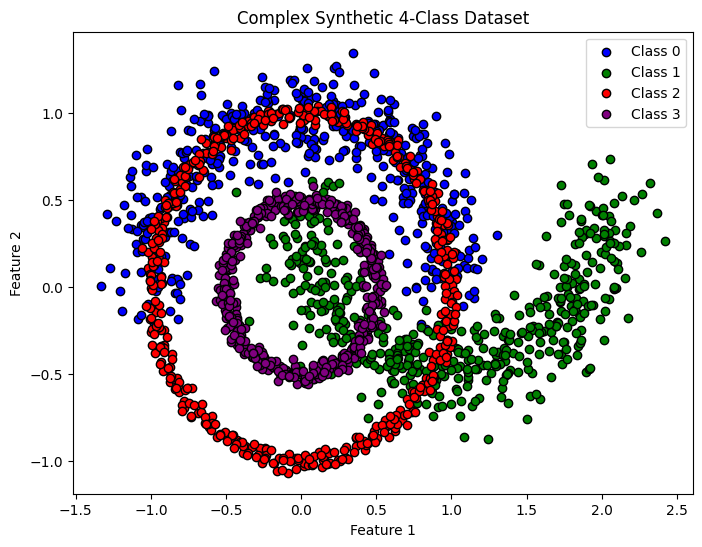

In [ ]:
import pandas as pd

# Specify the path to your CSV file
csv_file = '/content/DWS_Simulation.csv'

# Read the CSV file
df = pd.read_csv(csv_file)

# If you want to convert the DataFrame back to numpy arrays
X = df[['Feature_1', 'Feature_2']].values
y = df['Label'].values

# Plot the data
plt.figure(figsize=(8, 6))

# Plot each class separately
colors = ['blue', 'green', 'red', 'purple']  # Colors for each class
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Labels for each class

for i in range(4):
    plt.scatter(X[y == i, 0], X[y == i, 1], edgecolor='k', color=colors[i], label=labels[i])

plt.title("Complex Synthetic 4-Class Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


# Build FCN

In [ ]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, input_features=116, num_classes=2, hidden_layers=2, units=256, activation_fn='ReLU'):
        super(Net, self).__init__()


        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_features, units))
        self.layers.append(getattr(nn, activation_fn)())
        self.layers.append(nn.BatchNorm1d(units))

        for i in range(hidden_layers - 1):
            units = units // 2
            self.layers.append(nn.Linear(units*2, units))
            self.layers.append(getattr(nn, activation_fn)())
            self.layers.append(nn.BatchNorm1d(units))


        self.layers.append(nn.Linear(units, num_classes))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define Dataloader, Train and Test Loop

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import numpy as np
import random
import os

random.seed(40)
np.random.seed(40)
torch.manual_seed(40)
torch.cuda.manual_seed(40)
torch.cuda.manual_seed_all(40)  # if using multi-GPU
os.environ['PYTHONHASHSEED'] = str(40)

# Configure PyTorch for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.long)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def create_data_loaders(data, labels, train_size=0.6, val_size=0.2,test_size = 0.2, batch_size=100, seed_number=40):

    # Split data into train and temp sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        data, labels, test_size=(val_size + test_size), stratify=labels, random_state=seed_number)

    # Split temp data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed_number)
    print(seed_number)
    # Create datasets
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    test_dataset = CustomDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=0)

    return train_loader, val_loader, test_loader



In [ ]:

def train_and_evaluate_model(model, train_loader, val_loader, test_loader,
                             criterion, opt_func, max_lr, n_epochs):
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0


    torch.cuda.empty_cache()
    optimizer = opt_func(list(model.parameters()), lr=max_lr)
    # OneCycleLR scheduler initialization
    sched = OneCycleLR(optimizer, max_lr, epochs=n_epochs, steps_per_epoch=len(train_loader))

    for epoch in range(n_epochs):
        model.train()
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            if  isinstance(criterion, nn.BCEWithLogitsLoss):

                 targets_one_hot = torch.zeros(targets.size(0), 4).to(targets.device).scatter_(1, targets.view(-1, 1), 1)



            if isinstance(criterion, DWS) :
                 loss= criterion(outputs, targets, inputs)
            elif isinstance(criterion, nn.BCEWithLogitsLoss):
                 loss = criterion(outputs, targets_one_hot)

            else:

                 loss = criterion(outputs, targets.long())


            loss.backward()
            optimizer.step()

            sched.step()  # Update the learning rate

            _, predicted_train = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted_train == targets).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        predictions = []
        ground_truth = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                _, predicted_val = torch.max(outputs, 1)
                predictions.extend(predicted_val.tolist())
                ground_truth.extend(targets.tolist())

        val_accuracy = balanced_accuracy_score(ground_truth, predictions)
        val_accuracies.append(val_accuracy)


        print(f"Epoch {epoch + 1}/{n_epochs}: Training accuracy: {train_accuracies[-1] * 100:.2f}%, Validation accuracy: {val_accuracies[-1] * 100:.2f}%")


    metrics, y_test = test_model_1(model, test_loader)


    # Integrate results into a single dictionary
    results = {
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "test_metrics": metrics
    }

    return results




In [ ]:
def test_model_1(model, test_loader):
    # Set model to evaluation mode
    model.eval()

    y_true = []
    y_pred = []
    y_scores = []

    # Initialize metrics
    metrics = {}

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_scores.extend(outputs.tolist())
            y_true.extend(targets.tolist())
            y_pred.extend(predicted.tolist())

    # Convert scores to probabilities for AUC computation
    y_scores = torch.softmax(torch.tensor(y_scores), dim=1).numpy()

    # Compute metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
    # metrics['auc_score'] = roc_auc_score(y_true, y_scores, multi_class='ovr')

    # Calculate accuracy for each class
    cm = confusion_matrix(y_true, y_pred)
    metrics['class_accuracy'] = cm.diagonal() / cm.sum(axis=1)

    print(f"Test Metrics:\n Accuracy: {metrics['accuracy']:.4f}, Balanced_accuracy: {metrics['balanced_accuracy']:.4f}, ")
    for i, acc in enumerate(metrics['class_accuracy']):
        print(f"Class {i} Accuracy: {acc:.4f}")

    # Return the metrics and the predictions
    return metrics, y_pred

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracies(result):
    """
    Plots training and validation accuracies from a combined result.

    Args:
    result (tuple/list): A tuple or list where the first element is a list of training accuracies
                         and the second element is a list of validation accuracies.
    """
    train_accuracies = result['train_accuracies']
    val_accuracies = result['val_accuracies']
    epochs = range(1, len(train_accuracies) + 1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage example:
# Assume 'result' is a tuple or a list in the form of (train_accuracies, val_accuracies)
# plot_accuracies(result)


# The DWS Loss

In [ ]:
class DWS(nn.Module):
    def __init__(self, num_classes, p=1):
        super(DWS, self).__init__()
        self.num_classes = num_classes
        self.p = p  # Use 1 for L1 regularization, 2 for L2
        self.sinkhorn_loss = SamplesLoss("sinkhorn", p=1, blur=0.000000000001,scaling=0.85, debias=True,backend="tensorized")
        # self.sinkhorn_loss = SamplesLoss("sinkhorn", p=1, blur=0.000000000001,scaling=0.8, debias=True,backend="tensorized")


    def forward(self, outputs, targets, data):

        loss_components = []
        loss = 0
        loss_total = 0
        probs = torch.softmax(outputs, dim=1).requires_grad_(True)


        for i in range(probs.shape[1]):

            Gound_data = data[targets == i, :] #Ground truth data location
            num_samples_class_i = (targets == i).sum().item()
            ori_pred = torch.ones((num_samples_class_i, 1)).float().to(targets.device) #Ground truth probability
            ori_pred_normal = ori_pred / ori_pred.sum().to(targets.device) #Normalize Ground Truth probability


            weighted_data = data #Predicted data location
            weight_pred = probs[:, i] / probs[:, i].sum() #Predicted probability for each sample
            weight_pred_normal = weight_pred[:, None].requires_grad_(True)#Normalize Predicted probability for each sample


            if Gound_data.size(0) > 0: #Compute the WD between ground truth and predicted probability

                loss = self.sinkhorn_loss(weight_pred_normal,  weighted_data , ori_pred_normal, Gound_data)
                loss.requires_grad_(True)
                loss.retain_grad()
                loss_components.append( loss)

            else:
                print(f"Size of the selected_data tensor is smaller in class {i}")

        loss_total = sum(loss_components)
        loss_total.requires_grad_(True)
        #dif_3 = dif_ori.requires_grad_()
        # print(dif)
        return  loss_total

# GPU Helper Functions


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader, val_loader, test_loader = train_loader, val_loader, test_loader = create_data_loaders(X,y,train_size=0.6, val_size=0.2, test_size=0.2, batch_size=600, seed_number=40)

40


In [ ]:
import torch
import numpy as np
import random
import os

random.seed(40)
np.random.seed(40)
torch.manual_seed(40)
torch.cuda.manual_seed(40)
torch.cuda.manual_seed_all(40)  # if using multi-GPU
os.environ['PYTHONHASHSEED'] = str(40)

# Configure PyTorch for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = get_default_device()
device

device(type='cuda')

In [ ]:
import torch
import numpy as np
import random
import os

random.seed(40)
np.random.seed(40)
torch.manual_seed(40)
torch.cuda.manual_seed(40)
torch.cuda.manual_seed_all(40)  # if using multi-GPU
os.environ['PYTHONHASHSEED'] = str(40)

# Configure PyTorch for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_dl= DeviceDataLoader(train_loader,device)
valid_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

# Train the DWS Loss

In [ ]:
random.seed(40)
np.random.seed(40)
torch.manual_seed(40)
torch.cuda.manual_seed(40)
torch.cuda.manual_seed_all(40)  # if using multi-GPU
os.environ['PYTHONHASHSEED'] = str(40)

# Configure PyTorch for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

model1 = Net(input_features=2, num_classes=4, hidden_layers=4, units=512, activation_fn='ReLU')
model = to_device(model1, device)
# CustomLoss(3).reset_weights()
result_dws = train_and_evaluate_model(model,train_dl,valid_dl,test_dl,DWS(4),optim.AdamW,0.01,100)
print(  result_dws)

Epoch 1/100: Training accuracy: 32.75%, Validation accuracy: 25.00%
Epoch 2/100: Training accuracy: 62.00%, Validation accuracy: 30.50%
Epoch 3/100: Training accuracy: 67.42%, Validation accuracy: 39.25%
Epoch 4/100: Training accuracy: 69.75%, Validation accuracy: 41.25%
Epoch 5/100: Training accuracy: 73.00%, Validation accuracy: 57.25%
Epoch 6/100: Training accuracy: 74.17%, Validation accuracy: 70.25%
Epoch 7/100: Training accuracy: 74.83%, Validation accuracy: 71.75%
Epoch 8/100: Training accuracy: 75.25%, Validation accuracy: 73.25%
Epoch 9/100: Training accuracy: 74.50%, Validation accuracy: 72.75%
Epoch 10/100: Training accuracy: 74.83%, Validation accuracy: 73.00%
Epoch 11/100: Training accuracy: 75.08%, Validation accuracy: 73.75%
Epoch 12/100: Training accuracy: 77.00%, Validation accuracy: 75.50%
Epoch 13/100: Training accuracy: 76.50%, Validation accuracy: 76.00%
Epoch 14/100: Training accuracy: 75.75%, Validation accuracy: 76.25%
Epoch 15/100: Training accuracy: 75.33%, Va

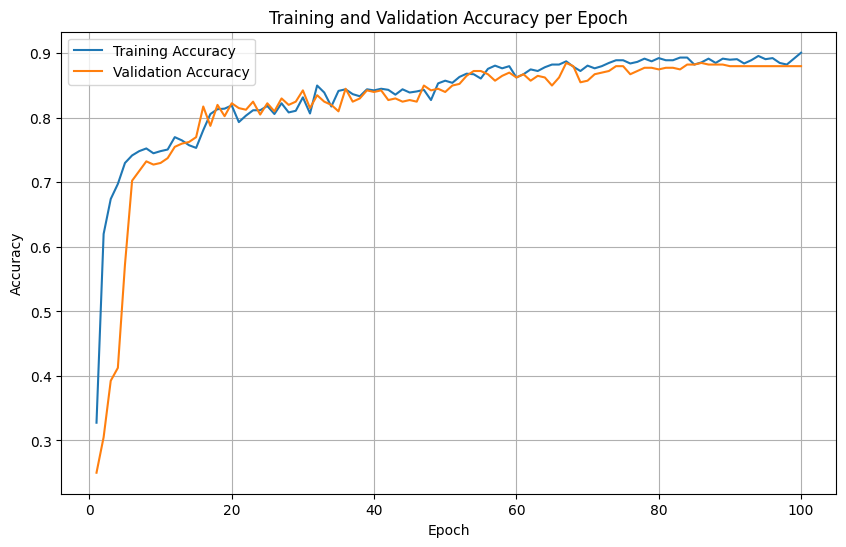

In [ ]:
plot_accuracies(result_dws)

# Train Cross Entropy

In [ ]:


random.seed(40)
np.random.seed(40)
torch.manual_seed(40)
torch.cuda.manual_seed(40)
torch.cuda.manual_seed_all(40)  # if using multi-GPU
os.environ['PYTHONHASHSEED'] = str(40)
# Configure PyTorch for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

model1 = Net(input_features=2, num_classes=4, hidden_layers=4, units=512, activation_fn='ReLU')
model = to_device(model1, device)
result_ce = train_and_evaluate_model(model, train_dl, valid_dl, test_dl, nn.CrossEntropyLoss(), optim.AdamW, 0.01,100)


Epoch 1/100: Training accuracy: 38.33%, Validation accuracy: 25.00%
Epoch 2/100: Training accuracy: 72.67%, Validation accuracy: 28.25%
Epoch 3/100: Training accuracy: 74.08%, Validation accuracy: 41.75%
Epoch 4/100: Training accuracy: 74.83%, Validation accuracy: 43.25%
Epoch 5/100: Training accuracy: 77.25%, Validation accuracy: 63.25%
Epoch 6/100: Training accuracy: 78.92%, Validation accuracy: 66.00%
Epoch 7/100: Training accuracy: 80.00%, Validation accuracy: 67.00%
Epoch 8/100: Training accuracy: 80.25%, Validation accuracy: 66.25%
Epoch 9/100: Training accuracy: 80.83%, Validation accuracy: 69.00%
Epoch 10/100: Training accuracy: 82.83%, Validation accuracy: 72.25%
Epoch 11/100: Training accuracy: 83.42%, Validation accuracy: 73.50%
Epoch 12/100: Training accuracy: 83.58%, Validation accuracy: 74.75%
Epoch 13/100: Training accuracy: 83.58%, Validation accuracy: 79.00%
Epoch 14/100: Training accuracy: 83.83%, Validation accuracy: 79.75%
Epoch 15/100: Training accuracy: 83.08%, Va

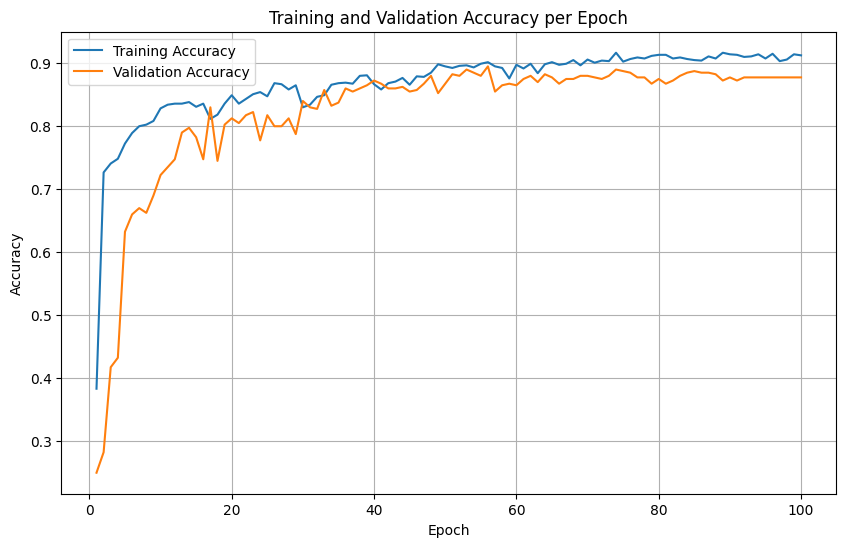

In [ ]:
plot_accuracies(result_ce)

# Train Cross Entropy with Logit Loss

In [ ]:
import torch
import numpy as np
import random
import os
import torch.optim as optim
import torch
import torch.nn as nn
random.seed(40)
np.random.seed(40)
torch.manual_seed(40)
torch.cuda.manual_seed(40)
torch.cuda.manual_seed_all(40)  # if using multi-GPU
# os.environ['PYTHONHASHSEED'] = str(40)

# Configure PyTorch for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random.seed(40)
np.random.seed(40)
torch.manual_seed(40)
torch.cuda.manual_seed(40)
torch.cuda.manual_seed_all(40)  # if using multi-GPU
os.environ['PYTHONHASHSEED'] = str(40)
model1 = Net(input_features=2, num_classes=4, hidden_layers=4, units=512, activation_fn='ReLU')
model = to_device(model1, device)
result_Logit = train_and_evaluate_model(model, train_dl, valid_dl, test_dl, nn.BCEWithLogitsLoss(), optim.AdamW, 0.01,100)


Epoch 1/100: Training accuracy: 38.92%, Validation accuracy: 25.00%
Epoch 2/100: Training accuracy: 73.42%, Validation accuracy: 25.00%
Epoch 3/100: Training accuracy: 73.42%, Validation accuracy: 40.50%
Epoch 4/100: Training accuracy: 74.08%, Validation accuracy: 45.00%
Epoch 5/100: Training accuracy: 74.67%, Validation accuracy: 60.25%
Epoch 6/100: Training accuracy: 75.42%, Validation accuracy: 64.00%
Epoch 7/100: Training accuracy: 77.58%, Validation accuracy: 69.00%
Epoch 8/100: Training accuracy: 79.08%, Validation accuracy: 72.75%
Epoch 9/100: Training accuracy: 79.42%, Validation accuracy: 74.75%
Epoch 10/100: Training accuracy: 80.08%, Validation accuracy: 75.50%
Epoch 11/100: Training accuracy: 79.50%, Validation accuracy: 76.75%
Epoch 12/100: Training accuracy: 81.67%, Validation accuracy: 77.00%
Epoch 13/100: Training accuracy: 81.67%, Validation accuracy: 80.50%
Epoch 14/100: Training accuracy: 81.75%, Validation accuracy: 76.50%
Epoch 15/100: Training accuracy: 83.00%, Va

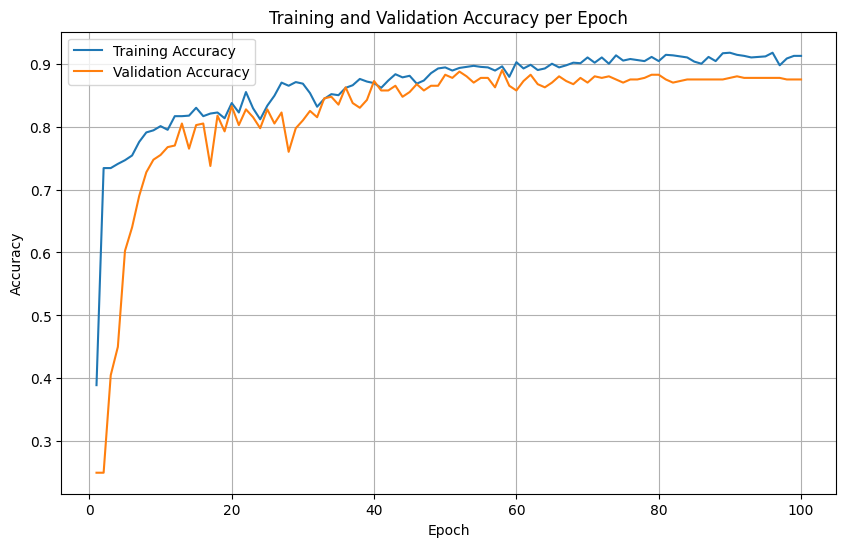

In [ ]:
plot_accuracies(result_Logit)

# Train the Focal Loss

In [ ]:
focal_loss = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='FocalLoss',
	alpha=torch.tensor([1.0,1.0,1.0,1.0 ]).to(device),
	gamma=2,
	reduction='mean',
	force_reload=False
)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/adeelh/pytorch-multi-class-focal-loss/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
random.seed(40)
np.random.seed(40)
torch.manual_seed(40)
torch.cuda.manual_seed(40)
torch.cuda.manual_seed_all(40)  # if using multi-GPU
os.environ['PYTHONHASHSEED'] = str(40)

# Configure PyTorch for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(40)
model1 = Net(input_features=2, num_classes=4, hidden_layers=4, units=512, activation_fn='ReLU')
model = to_device(model1, device)
result_focal = train_and_evaluate_model(model, train_dl, valid_dl, test_dl, focal_loss, optim.AdamW, 0.01,100)


Epoch 1/100: Training accuracy: 39.75%, Validation accuracy: 25.00%
Epoch 2/100: Training accuracy: 72.42%, Validation accuracy: 27.50%
Epoch 3/100: Training accuracy: 75.50%, Validation accuracy: 42.50%
Epoch 4/100: Training accuracy: 76.67%, Validation accuracy: 45.00%
Epoch 5/100: Training accuracy: 77.92%, Validation accuracy: 52.25%
Epoch 6/100: Training accuracy: 80.25%, Validation accuracy: 59.50%
Epoch 7/100: Training accuracy: 81.17%, Validation accuracy: 68.25%
Epoch 8/100: Training accuracy: 81.33%, Validation accuracy: 73.50%
Epoch 9/100: Training accuracy: 82.08%, Validation accuracy: 73.25%
Epoch 10/100: Training accuracy: 83.58%, Validation accuracy: 72.75%
Epoch 11/100: Training accuracy: 82.92%, Validation accuracy: 77.00%
Epoch 12/100: Training accuracy: 84.50%, Validation accuracy: 78.25%
Epoch 13/100: Training accuracy: 85.00%, Validation accuracy: 80.00%
Epoch 14/100: Training accuracy: 84.00%, Validation accuracy: 78.00%
Epoch 15/100: Training accuracy: 86.17%, Va

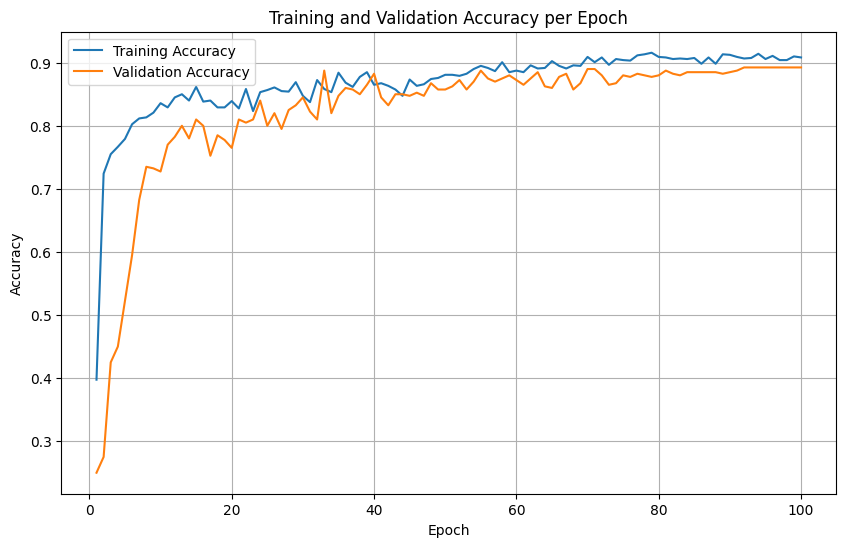

In [ ]:
plot_accuracies(result_focal)

# Train the Hinge Loss

In [ ]:
random.seed(40)
np.random.seed(40)
torch.manual_seed(40)
torch.cuda.manual_seed(40)
torch.cuda.manual_seed_all(40)  # if using multi-GPU
os.environ['PYTHONHASHSEED'] = str(40)

# Configure PyTorch for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(40)
model1 = Net(input_features=2, num_classes=4, hidden_layers=4, units=512, activation_fn='ReLU')
model = to_device(model1, device)
result_hinge = train_and_evaluate_model(model, train_dl, valid_dl, test_dl, nn.MultiMarginLoss(p=2), optim.AdamW, 0.01,100)


Epoch 1/100: Training accuracy: 39.58%, Validation accuracy: 25.00%
Epoch 2/100: Training accuracy: 72.67%, Validation accuracy: 25.25%
Epoch 3/100: Training accuracy: 75.33%, Validation accuracy: 38.00%
Epoch 4/100: Training accuracy: 77.33%, Validation accuracy: 44.75%
Epoch 5/100: Training accuracy: 78.42%, Validation accuracy: 45.25%
Epoch 6/100: Training accuracy: 80.75%, Validation accuracy: 50.00%
Epoch 7/100: Training accuracy: 82.08%, Validation accuracy: 58.25%
Epoch 8/100: Training accuracy: 83.33%, Validation accuracy: 66.00%
Epoch 9/100: Training accuracy: 82.50%, Validation accuracy: 69.00%
Epoch 10/100: Training accuracy: 82.92%, Validation accuracy: 75.00%
Epoch 11/100: Training accuracy: 81.25%, Validation accuracy: 78.00%
Epoch 12/100: Training accuracy: 85.00%, Validation accuracy: 80.00%
Epoch 13/100: Training accuracy: 86.25%, Validation accuracy: 78.50%
Epoch 14/100: Training accuracy: 85.25%, Validation accuracy: 79.50%
Epoch 15/100: Training accuracy: 86.00%, Va

# Comparison and Conclusion

In [ ]:
def print_test_metrics(results):
    # Assuming results is a dictionary with 'test_metrics' key
    metrics = results['test_metrics']

    print(f"Test Metrics:\n Accuracy: {metrics['accuracy']:.4f}, "
          f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}, "
          f"F1 Score: {metrics['f1_score']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}")

    if 'class_accuracy' in metrics:
        for i, acc in enumerate(metrics['class_accuracy']):
            print(f"Class {i} Accuracy: {acc:.4f}")

# Example usage with your results from different models
print("Metrics for DWS:")
print_test_metrics(result_dws)

print("\nMetrics for Focal:")
print_test_metrics(result_focal)


print("\nMetrics for CE_Logit:")
print_test_metrics(result_Logit)

print("\nMetrics for CE:")
print_test_metrics(result_ce)

print("\nMetrics for Hinge:")
print_test_metrics(result_hinge)


Metrics for DWS:
Test Metrics:
 Accuracy: 0.8800, Balanced Accuracy: 0.8800, F1 Score: 0.8795, Precision: 0.8846, Recall: 0.8800
Class 0 Accuracy: 0.7200
Class 1 Accuracy: 0.9400
Class 2 Accuracy: 0.8700
Class 3 Accuracy: 0.9900

Metrics for Focal:
Test Metrics:
 Accuracy: 0.8550, Balanced Accuracy: 0.8550, F1 Score: 0.8547, Precision: 0.8605, Recall: 0.8550
Class 0 Accuracy: 0.7000
Class 1 Accuracy: 0.9300
Class 2 Accuracy: 0.8600
Class 3 Accuracy: 0.9300

Metrics for CE_Logit:
Test Metrics:
 Accuracy: 0.8575, Balanced Accuracy: 0.8575, F1 Score: 0.8574, Precision: 0.8621, Recall: 0.8575
Class 0 Accuracy: 0.7100
Class 1 Accuracy: 0.9400
Class 2 Accuracy: 0.8500
Class 3 Accuracy: 0.9300

Metrics for CE:
Test Metrics:
 Accuracy: 0.8600, Balanced Accuracy: 0.8600, F1 Score: 0.8597, Precision: 0.8655, Recall: 0.8600
Class 0 Accuracy: 0.7000
Class 1 Accuracy: 0.9400
Class 2 Accuracy: 0.8600
Class 3 Accuracy: 0.9400

Metrics for Hinge:
Test Metrics:
 Accuracy: 0.8600, Balanced Accuracy: 0.8